<a href="https://colab.research.google.com/github/Maorytzio/Bank-s-products-prediction/blob/main/Solution_of_Insait_DS_candidates'_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greetings!
> You received this jupyter notebook as we believe this can be a great fit. <br>
> The goal of this notebook is to understand our challenges better <br> and assess your proficiency in python & pandas.

### Several remarks:
* You are welcome to use the internet, consult, and use any available sources.
* There is no time limit, and we do not monitor any versioning or pace. Take your time and have fun.
* The notebook should take up to two hours. If it takes more than that, please reach out.
We tried to create an intriguing assignment. If you have any feedback - we'll be happy to hear.
* A text cell decorated with "👷" will be followed by a code cell you are welcome to fill in.

### **Make sure the notebook runs end to end before submission**

# **The products recommendation notebook**
The data at hand represents 12,000 bank clients and their monthly financial status.
<br> The data is featured as a tabular schema, where each row contains 48 features.
>The first 24 features are client-level entities such as age, residence country, and the joining channel.
<br>The last 24 features are the **products** the client owns in a specified month (`Status_Dt`).

Our task is to *forecast* which products a client will add or remove next month, given that we have all past information on the client.

# Logistics

In [27]:
# You will probably need to run this cell twice,
# as google colab has runtime issues after installing some libraries
# (press the "Restart runtime" button in the output cell)
!pip install --upgrade gdown

In [4]:
# Download and extract the dataset
!rm -rf sample_data
!mkdir data & gdown 1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu -O data/features_products.zip
!unzip data/features_products.zip -d data/features_products
!find . -name "*.zip" ! -iname features_products.zip | while read filename; do unzip -o -d "`dirname "$filename"`" "$filename"; done;
!find . -name "*.zip" -delete

Downloading...
From (original): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu
From (redirected): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu&confirm=t&uuid=57de3595-311c-4a77-958f-3b99cb424d41
To: /content/data/features_products.zip
100% 240M/240M [00:06<00:00, 39.2MB/s]
Archive:  data/features_products.zip
  inflating: data/features_products/sample_submission.csv.zip  
  inflating: data/features_products/test_ver2.csv.zip  
  inflating: data/features_products/train_ver2.csv.zip  
Archive:  ./data/features_products/train_ver2.csv.zip
  inflating: ./data/features_products/train_ver2.csv  
Archive:  ./data/features_products/sample_submission.csv.zip
  inflating: ./data/features_products/sample_submission.csv  
Archive:  ./data/features_products/test_ver2.csv.zip
  inflating: ./data/features_products/test_ver2.csv  


In [3]:
# Import libraries and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)
import warnings
warnings.filterwarnings("ignore")


Populating the interactive namespace from numpy and matplotlib


In [5]:
# Sample the dataset (We only want to experiment with the data).
limit_rows   = 7000000

df           = pd.read_csv("data/features_products/train_ver2.csv",dtype={
                                                    "sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str},
                                                     nrows=limit_rows)



In [12]:
# The original schema was in Spanish. We will rename the columns for readability.
df.columns = ['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age', 'Join_Dt',
                'Is_New_Cust', 'Cust_Since', 'Relship_Status','Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg',
                'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
                'Address_Type', 'Cust_Province_Cd', 'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
                'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1', 'Loans',
                'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

Cust_Segment_translator = {
    '03 - UNIVERSITARIO': 'University Student',
    '02 - PARTICULARES': 'Individuals',
    '01 - NEGOCIOS': 'Businesses',
}
Cust_Sex_translator= {'H':'M','V':'F'}

df['Cust_Segment'] = df['Cust_Segment'].map(Cust_Segment_translator)
df['Cust_Sex'] = df['Cust_Sex'].map(Cust_Sex_translator)


# Sample the dataset (We only want to experiment with the data).
unique_ids   = pd.Series(df["Cust_ID"].unique())
limit_people = int(1.2e4)
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.Cust_ID.isin(unique_id)]




df.drop_duplicates(subset=['Emp_Status'])

,Status_Dt,Cust_ID,Emp_Status,Cust_Ctry,Cust_Sex,Age,Join_Dt,Is_New_Cust,Cust_Since,Relship_Status,...,Mortgage,Pension1,Loans,Taxes,Credit_Card,Securities,Home_Acct,Payroll,Pension2,Direct_Debit
51,2015-01-28,1050706,N,ES,NaN,33,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1029,2015-01-28,1051017,NaN,NaN,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
106341,2015-01-28,882398,A,AD,NaN,44,2010-06-11,0,61,1.0,...,0,1,0,0,1,1,0,0.0,0.0,0
396180,2015-01-28,72711,B,ES,NaN,48,1997-09-30,0,214,1.0,...,0,0,0,1,0,0,0,0.0,0.0,1


In [13]:
# Cast relevant data types
date_attribs = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
for attrib in date_attribs:
    df[attrib] = pd.to_datetime(df[attrib],format="%Y-%m-%d")

numeric_attribs = ['Age', 'Is_New_Cust', 'Cust_Since', 'Relship_Status', 'Address_Type', 'Cust_Active_Status']
for attrib in numeric_attribs:
    df[attrib] = pd.to_numeric(df[attrib], downcast='integer',errors='coerce')






# Exploratory Data Analysis 👷

### The task in this phase is to analyze the data.
#### Think of at least 3-5 useful EDA plots to present that helps understand the underlying statistics. Explain why you selected these plots. What insights/questions did you also find during the EDA?
*Remember - The goal is to predict which items customers will add in the following month.*

> You are not obligated to submit all plots and analyses you perform.
<br>Try to understand the data as good as possible.


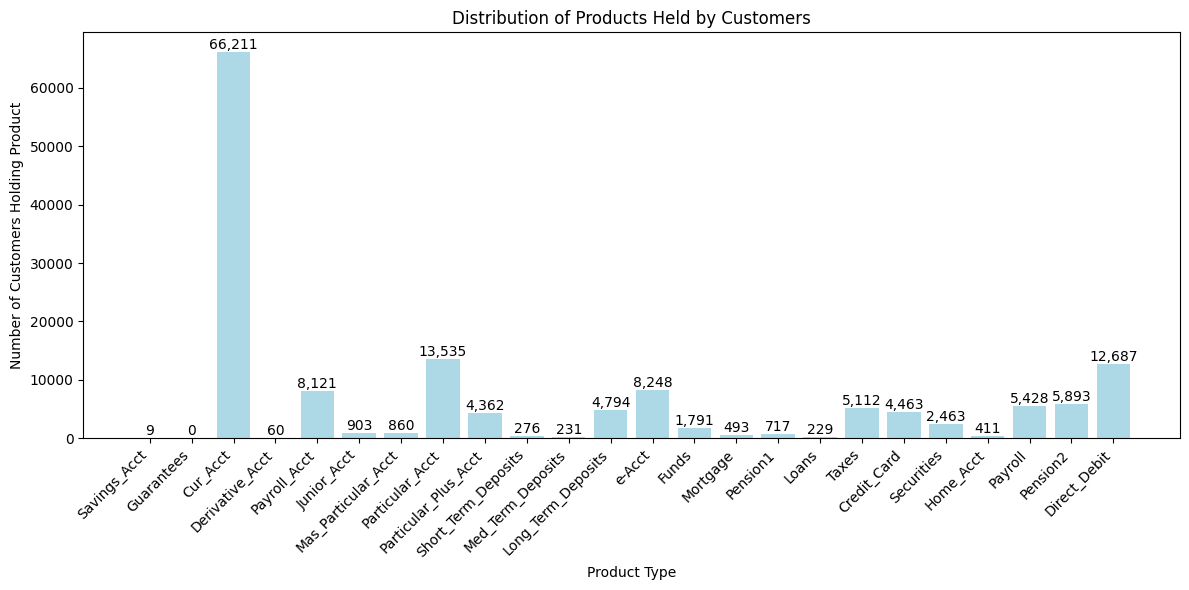

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the x and y data
x = product_counts.index
y = product_counts.values

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(x, y, color='lightblue')

# Add labels on top of the bars for every bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval):,}', ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.xlabel('Product Type')
plt.ylabel('Number of Customers Holding Product')
plt.title('Distribution of Products Held by Customers')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


# Let's get down, let's get down to business! 🕺💃 👷

After understanding our data better, we would like to train a model to predict the following products a client is about to add or remove.

The development will be segmented into *three* steps.

1.   Create a label vector for each month:
<br>The label vector for each `<client, date>` is the *difference* between the products the client holds in `<date>` and the products of the same client in the consecutive month.<br>
For example, if a client `X` holds a credit card, and does not have a loan or a savings account in March 2019 (translates to the vector `[1,0,0]`) and canceled the credit card in April 2019 but opened a savings account (translates to the vector `[0,0,1]`) - The label for `X, March 2019` will be `[-1,0,1].` <br><br>

2.   Use Feature engineering and Feature selection methods to enrich the training dataset.

3. Use any relevant classification algorithm to predict the shift between consecutive months.



## Create labels

In [8]:
# Create a label feature vector per <Cust_ID,Status_Dt>
# The label vector will be of length 27 and will represent the change in products between consecutive months
# Create a `next_data_label` dataframe with the following columns:
# ['Cust_ID','Status_Dt', 'Status_Dt_shifted', ... 24 difference product difference label columns ...]
# The name of each label column will be the original column name with the added suffix '_change`
# e.g `Funds_change`.


df_shifted = df.copy()

# Shift the 'Status_Dt' and product columns by 1 for each customer
df_shifted['Status_Dt_shifted'] = df_shifted.groupby('Cust_ID')['Status_Dt'].shift(-1)


# Select only the last 24 product-related columns (replace with actual product column names if needed)
product_columns = df.columns[-24:]

for product in product_columns:
    # Convert product columns to numeric, if needed (errors='coerce' will turn non-numeric values into NaN)
    df_shifted[product] = pd.to_numeric(df_shifted[product], errors='coerce')

    # Calculate the change in product between consecutive months for each customer
    df_shifted[product + '_change'] = df_shifted.groupby('Cust_ID')[product].diff(-1)

next_data_label = df_shifted[['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [product + '_change' for product in product_columns]]



# Display
print(next_data_label.drop_duplicates(subset='Cust_ID').head().to_string(),  end='\n\n')
# print(next_data_label['Cust_ID'].nunique())
next_data_label.head()


     Cust_ID   Status_Dt Status_Dt_shifted  Savings_Acct_change  Guarantees_change  Cur_Acct_change  Derivative_Acct_change  Payroll_Acct_change  Junior_Acct_change  Mas_Particular_Acct_change  Particular_Acct_change  Particular_Plus_Acct_change  Short_Term_Deposits_change  Med_Term_Deposits_change  Long_Term_Deposits_change  e-Acct_change  Funds_change  Mortgage_change  Pension1_change  Loans_change  Taxes_change  Credit_Card_change  Securities_change  Home_Acct_change  Payroll_change  Pension2_change  Direct_Debit_change
51   1050706  2015-01-28        2015-02-28                  0.0                0.0              0.0                     0.0                  0.0                 0.0                         0.0                     0.0                          0.0                         0.0                       0.0                        0.0            0.0           0.0              0.0              0.0           0.0           0.0                 0.0                0.0               

,Cust_ID,Status_Dt,Status_Dt_shifted,Savings_Acct_change,Guarantees_change,Cur_Acct_change,Derivative_Acct_change,Payroll_Acct_change,Junior_Acct_change,Mas_Particular_Acct_change,...,Mortgage_change,Pension1_change,Loans_change,Taxes_change,Credit_Card_change,Securities_change,Home_Acct_change,Payroll_change,Pension2_change,Direct_Debit_change
51,1050706,2015-01-28,2015-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,1050647,2015-01-28,2015-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,1050511,2015-01-28,2015-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,1050512,2015-01-28,2015-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,1050553,2015-01-28,2015-02-28,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Because we only care about behavioural changes, we filter rows with no product change in the consecutive month.
trainable_objects = next_data_label.iloc[:,3:].any(axis=1).to_numpy().nonzero()[0]

next_data_label_relevant = next_data_label.iloc[trainable_objects]

# print(list(next_data_label_relevant.columns))
print(next_data_label_relevant['Cust_ID'].nunique())
print(next_data_label_relevant.drop_duplicates('Cust_ID').head().to_string())


2281
      Cust_ID   Status_Dt Status_Dt_shifted  Savings_Acct_change  Guarantees_change  Cur_Acct_change  Derivative_Acct_change  Payroll_Acct_change  Junior_Acct_change  Mas_Particular_Acct_change  Particular_Acct_change  Particular_Plus_Acct_change  Short_Term_Deposits_change  Med_Term_Deposits_change  Long_Term_Deposits_change  e-Acct_change  Funds_change  Mortgage_change  Pension1_change  Loans_change  Taxes_change  Credit_Card_change  Securities_change  Home_Acct_change  Payroll_change  Pension2_change  Direct_Debit_change
115   1050553  2015-01-28        2015-02-28                  0.0                0.0             -1.0                     0.0                  0.0                 0.0                         0.0                     0.0                          0.0                         0.0                       0.0                        0.0            0.0           0.0              0.0              0.0           0.0           0.0                 0.0                0.0        

## Create features

#### Feature engineering 👨‍🔧 📏 📝 📊

---


Feature engineering is a crucial part of working with tabular data.
*italicized text*
We love new libraries and papers and try to be up-to-date as much as possible here at Insait.

Use any feature engineering method or library you know and love, and create new features to enrich your data.
You can choose to do automatic feature engineering or knowledge-based by manually thinking on logical correlations.

In [17]:
import pandas as pd

enriched_df = df.copy()

#  Age Group Feature
enriched_df['Age_Group'] = pd.cut(enriched_df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])

#  Relationship Duration in Years
enriched_df['Join_Dt'] = pd.to_datetime(enriched_df['Join_Dt'])
enriched_df['Status_Dt'] = pd.to_datetime(enriched_df['Status_Dt'])
enriched_df['Relship_Duration_Years'] = (enriched_df['Status_Dt'] - enriched_df['Join_Dt']).dt.days / 365

#  Income-to-Age Ratio
enriched_df['Income_Age_Ratio'] = enriched_df['Gross_HHLD_Income'] / enriched_df['Age']

# High-Income Household Flag (assuming 50,000 as a threshold)
enriched_df['Is_High_Income'] = enriched_df['Gross_HHLD_Income'] > 50000

# Active Customer Flag (based on whether they have any active accounts/products)
active_cols = ['Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct', 'Junior_Acct',
               'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
               'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1',
               'Loans', 'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

enriched_df['Is_Active'] = enriched_df[active_cols].sum(axis=1) > 0

#  Foreign Resident Flag (customers living outside their country of origin)
enriched_df['Is_Foreign_Resident'] = enriched_df['Residence_Ctry'] != enriched_df['Cust_Ctry']

#  Customer Engagement Score (based on the number of products/services used)
enriched_df['Engagement_Score'] = enriched_df[active_cols].sum(axis=1)

#  Recent Customer Flag (customers who joined within the last year)
enriched_df['Is_Recent_Cust'] = enriched_df['Relship_Duration_Years'] < 1

#  Spouse Employment Flag (is the customer's spouse employed)
enriched_df['Is_Spouse_Employed'] = enriched_df['Is_Spouse_Emp'] == 'Y'

#  Province-Based Income Level (relative to average income in the province)
income_by_province = enriched_df.groupby('Cust_Province_Name')['Gross_HHLD_Income'].mean()
enriched_df['Province_Income_Level'] = enriched_df['Cust_Province_Name'].map(income_by_province)
enriched_df['Above_Province_Avg_Income'] = enriched_df['Gross_HHLD_Income'] > enriched_df['Province_Income_Level']

#  Employment-Based Product Usage (check if unemployed customers use fewer products)
enriched_df['Product_Count'] = enriched_df[active_cols].sum(axis=1)
enriched_df['Is_Employed'] = enriched_df['Emp_Status'] == 'Y'

#  Deceased Flag (binary flag for deceased customers)
enriched_df['Is_Deceased'] = enriched_df['Deceased_Flg'] == 'Y'



# Display the enriched dataframe
enriched_df['Cust_Sex']



array([nan], dtype=object)

#### Feature Selection
The financial datasets we use at Insait have hundreds of columns.

Training on such massive datasets lead to bad performance and extended training time.

Suggest a feature selection method (Using an open-source library is welcomed), and filter the provided dataset

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd


# Convert 'Cust_Type_Mth_Beg' to float64, handling errors
enriched_df['Cust_Type_Mth_Beg'] = pd.to_numeric(enriched_df['Cust_Type_Mth_Beg'], errors='coerce')

# Optionally, you can fill NaN values with a specific value or drop rows
# For example, to fill NaN with 0:
# enriched_df['Cust_Type_Mth_Beg'].fillna(0, inplace=True)

# Convert 'Is_Active' column values to 1 for True and 0 for False
enriched_df['Is_Active'] = enriched_df['Is_Active'].astype(int)

# Dropping non-numeric columns and the target column 'Is_Active'
X = enriched_df.select_dtypes(include=['float64', 'int64']).drop(columns=['Is_Active'])
y = enriched_df['Is_Active']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier to determine feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances and select the top 10 most important features
feature_importances = clf.feature_importances_
important_indices = feature_importances.argsort()[-10:]  # Get indices of top 10 features

# Create a new DataFrame with the selected top 10 features from the original DataFrame
selected_features = X.columns[important_indices].tolist()

# Ensure 'Cust_Type_Mth_Beg' is included in the selected features
if 'Cust_Type_Mth_Beg' not in selected_features:
    selected_features.append('Cust_Type_Mth_Beg')

# Create the new dataset enriched_selected_df
enriched_selected_df = enriched_df[selected_features]

enriched_selected_df.head()




,Direct_Debit,Relship_Duration_Years,Cust_Since,e-Acct,Payroll_Acct,Particular_Acct,Cust_Active_Status,Cur_Acct,Product_Count,Engagement_Score,Cust_Type_Mth_Beg
88,0,2.468493,35.0,0,0,0,1.0,1,1.0,1.0,1.0
250,0,2.468493,35.0,0,0,0,0.0,1,1.0,1.0,1.0
287,0,2.468493,35.0,0,0,0,0.0,1,1.0,1.0,1.0
357,1,2.468493,35.0,0,0,0,1.0,1,2.0,2.0,1.0
379,0,2.468493,35.0,0,0,0,0.0,1,1.0,1.0,1.0


In [111]:
# 2. Merge the enriched_selected_df with the labels (the products difference vector <next_data_label_relevant>)
# Call the final df `features_labels`

# Reset index to ensure alignment and avoid duplicates
next_data_label_relevant_reset = next_data_label_relevant.reset_index(drop=True)
enriched_selected_df_reset = enriched_selected_df.reset_index(drop=True)

# Identify and drop duplicated columns in next_data_label_relevant
# Keep only the first occurrence of any duplicated column
features_labels = pd.concat([next_data_label_relevant_reset.loc[:, ~next_data_label_relevant_reset.columns.duplicated()],
                              enriched_selected_df_reset], axis=1)




## Modeling

In [112]:
# Beware! a random train,test split will not work here, as we will leak data to future occurances.
# We will take samples where the next month is the last month in the db as our testing data, and the rest as train.

next_date_last = (features_labels.Status_Dt_shifted == features_labels.Status_Dt_shifted.max())
train, test = features_labels[next_date_last], features_labels[~next_date_last]

## Training
### It's the final countdown 🍒👷

In [113]:
# We provide below a helper to preprocess the training features before entering to the model.
from sklearn.preprocessing import LabelEncoder
def prepare_for_model(df):

  features = df.loc[:,~df.columns.str.endswith('_change')].drop(['Cust_ID','Status_Dt'],axis=1)
  labels = df.loc[:,df.columns.str.endswith('_change')]
  features.loc[:,features.dtypes=='object'] = features.loc[:,features.dtypes=='object'].astype('category')


  columns_to_drop = ['Join_Dt', 'Status_Dt_shifted', 'Lst_Dt_Primary_Cust']
  existing_columns = [col for col in columns_to_drop if col in features.columns]
  features = features.drop(existing_columns, axis=1)

  features['Cust_Type_Mth_Beg'] = pd.to_numeric(features.Cust_Type_Mth_Beg, errors='coerce')

  for column in features.columns[features.dtypes == 'category']:
    features[column] = LabelEncoder().fit_transform(features[column])
  return features, labels

train_features, train_labels = prepare_for_model(train)
test_features, test_labels = prepare_for_model(test)

Index(['Cust_ID', 'Status_Dt', 'Status_Dt_shifted', 'Savings_Acct_change',
       'Guarantees_change', 'Cur_Acct_change', 'Derivative_Acct_change',
       'Payroll_Acct_change', 'Junior_Acct_change',
       'Mas_Particular_Acct_change', 'Particular_Acct_change',
       'Particular_Plus_Acct_change', 'Short_Term_Deposits_change',
       'Med_Term_Deposits_change', 'Long_Term_Deposits_change',
       'e-Acct_change', 'Funds_change', 'Mortgage_change', 'Pension1_change',
       'Loans_change', 'Taxes_change', 'Credit_Card_change',
       'Securities_change', 'Home_Acct_change', 'Payroll_change',
       'Pension2_change', 'Direct_Debit_change', 'Direct_Debit',
       'Relship_Duration_Years', 'Cust_Since', 'e-Acct', 'Payroll_Acct',
       'Particular_Acct', 'Cust_Active_Status', 'Cur_Acct', 'Product_Count',
       'Engagement_Score', 'Cust_Type_Mth_Beg'],
      dtype='object')


In [116]:
# There are several months where a client changed more than one item.
# Thus we are looking at a multioutput classification problem.
# Use any algorithm/ platform/ library you desire and train the above `train_features, train_labels`.
# Test on test_labels
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Ensure no NaN values in train_labels and test_labels
train_labels = train_labels.fillna(0)
test_labels = test_labels.fillna(0)

# Initialize the model
model = MultiOutputClassifier(RandomForestClassifier(random_state=42))

# Fit the model
model.fit(train_features, train_labels)

# Make predictions on the test set
yhat = model.predict(test_features)


In [122]:
# Evaluation code
for idx,col in enumerate(test_labels.columns):
  cm = confusion_matrix(test_labels[col].values,yhat[:,idx])
  cr = classification_report(test_labels[col].values,yhat[:,idx])
  print(f"Label: {col} \nconf\n {cm}, \nreport\n {cr}\n")


Index(['Savings_Acct_change', 'Guarantees_change', 'Cur_Acct_change',
       'Derivative_Acct_change', 'Payroll_Acct_change', 'Junior_Acct_change',
       'Mas_Particular_Acct_change', 'Particular_Acct_change',
       'Particular_Plus_Acct_change', 'Short_Term_Deposits_change',
       'Med_Term_Deposits_change', 'Long_Term_Deposits_change',
       'e-Acct_change', 'Funds_change', 'Mortgage_change', 'Pension1_change',
       'Loans_change', 'Taxes_change', 'Credit_Card_change',
       'Securities_change', 'Home_Acct_change', 'Payroll_change',
       'Pension2_change', 'Direct_Debit_change'],
      dtype='object')
Label: Savings_Acct_change 
conf
 [[92935]], 
report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     92935

    accuracy                           1.00     92935
   macro avg       1.00      1.00      1.00     92935
weighted avg       1.00      1.00      1.00     92935


Label: Guarantees_change 
conf
 [[92935]], 
report
 

What you can say about the results?

# This is it!
We hope you enjoyed this notebook.
Please share your thoughts and impressions, and send us a link to your notebook.
Talk to you soon:)